In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data importeren

Importeren van de data uit drive,
vul de authorization code in die verkregen wordt via de link of er wordt al direct een scherm opgebracht waar je kan inloggen.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/Schilderijen-Classificeren_Arthur-Huys/datasets" "/content/datasets"

Mounted at /gdrive


In [ ]:
import shutil
shutil.unpack_archive('datasets/Picasso_Rubens_400_100_100.zip','.','zip')

# creeëren datasets

Maken van 3 datasets (train, validation, test), met een bepaalde image size (zie colab "Optimal image size") en een batch size.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    "Picasso_Rubens_400_100_100/train",
    image_size=(224, 224),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    "Picasso_Rubens_400_100_100/validation",
    image_size=(224, 224),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    "Picasso_Rubens_400_100_100/test",
    image_size=(224, 224),
    batch_size=32)

Found 800 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


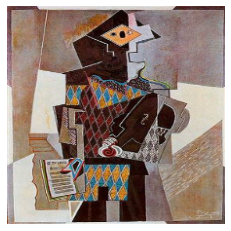

In [ ]:
import matplotlib.pyplot as plt
for images, _ in train_dataset.take(1):
  plt.imshow(images[0].numpy().astype("uint8"))
  plt.axis("off")

# VGG16

We maken gewoon gebruik van het basisch model, waarbij er veranderingen worden aangepast bij de laatste lagen. Dit doen we omdat dit probleem alleen binaire classificate is en deze model getraind zijn om honderden klasses te voorspellen.

Doordat we niet alle lagen moeten trainen gaan we de conv_base layers non_trainable maken:
```
conv_base.trainable = False
```



In [ ]:
conv_base = keras.applications.vgg16.VGG16(
weights="imagenet",
include_top=False)
conv_base.trainable = False

Omdat we gebruik maken van een kleine dataset kunnen we dit compenseren door de data iet wat aan te passen met data augmentation.

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),])

Bij het bouwen van de laatste lagen die het model vervolledigen heb ik gebruik gemaakt van de basisch settings.

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Hier heb ik een callback gecreerde zodanig dat we na het fitten nog wat values kunnen opvragen van tijdens het trainen, dit kunnen we dan later gebruiken om in een plot te zetten en te kijken wanneer het model aan overfitting doet.

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")]

Nu heb ik het model getraind op de train en validation set, met een aantal epchs van 100.

In [ ]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
25/25 [==============================] - 11s 364ms/step - loss: 7.6800 - accuracy: 0.9513 - val_loss: 6.1235 - val_accuracy: 0.9750
Epoch 2/100
25/25 [==============================] - 10s 350ms/step - loss: 2.9119 - accuracy: 0.9712 - val_loss: 7.7029 - val_accuracy: 0.9650
Epoch 3/100
25/25 [==============================] - 11s 363ms/step - loss: 3.2999 - accuracy: 0.9787 - val_loss: 6.1192 - val_accuracy: 0.9750
Epoch 4/100
25/25 [==============================] - 11s 355ms/step - loss: 2.5381 - accuracy: 0.9762 - val_loss: 7.0823 - val_accuracy: 0.9850
Epoch 5/100
25/25 [==============================] - 10s 350ms/step - loss: 1.6510 - accuracy: 0.9837 - val_loss: 16.0115 - val_accuracy: 0.9300
Epoch 6/100
25/25 [==============================] - 10s 353ms/step - loss: 3.9659 - accuracy: 0.9750 - val_loss: 9.8813 - val_accuracy: 0.9650
Epoch 7/100
25/25 [==============================] - 10s 350ms/step - loss: 2.3621 - accuracy: 0.9737 - val_loss: 7.9603 - val_accuracy

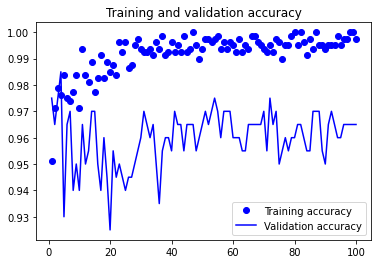

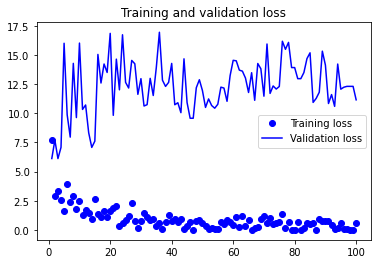

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

We zien aan deze grafieken dat dit model aan overfitting doet na ongeveer 10 epochs.

In [ ]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

7/7 [==============================] - 3s 214ms/step - loss: 5.7170 - accuracy: 0.9600
Test accuracy: 0.960


Wanneer we dan onze test data in het getrainde model steken krijgen we een accuracy van 96%, dit is zeer goed maar kan wel nog beter. Daarom zal ik nog 3 verschillende pretrained convets testen.

# Inception

Hier ga ik nu gebruik maken van het pretrained convnet Inception, voor de rest blijft de manier van werken gelijk aan het vorige model (VGG16).

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3( 
    include_top = False, 
    weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),])

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.inception_v3.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
25/25 [==============================] - 17s 403ms/step - loss: 58.0615 - accuracy: 0.7625 - val_loss: 4.8611 - val_accuracy: 0.9050
Epoch 2/100
25/25 [==============================] - 10s 345ms/step - loss: 23.5628 - accuracy: 0.8213 - val_loss: 3.5345 - val_accuracy: 0.9500
Epoch 3/100
25/25 [==============================] - 9s 309ms/step - loss: 11.6842 - accuracy: 0.9038 - val_loss: 5.1167 - val_accuracy: 0.9300
Epoch 4/100
25/25 [==============================] - 9s 308ms/step - loss: 13.1731 - accuracy: 0.8888 - val_loss: 3.7040 - val_accuracy: 0.9400
Epoch 5/100
25/25 [==============================] - 9s 307ms/step - loss: 13.2615 - accuracy: 0.8888 - val_loss: 15.8905 - val_accuracy: 0.8650
Epoch 6/100
25/25 [==============================] - 9s 309ms/step - loss: 7.0502 - accuracy: 0.9300 - val_loss: 13.1156 - val_accuracy: 0.8900
Epoch 7/100
25/25 [==============================] - 9s 307ms/step - loss: 9.2623 - accuracy: 0.9250 - val_loss: 3.6473 - val_accurac

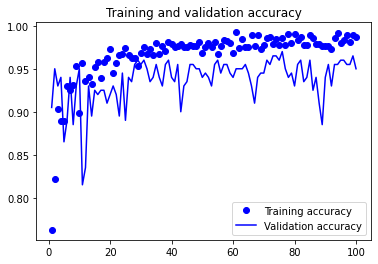

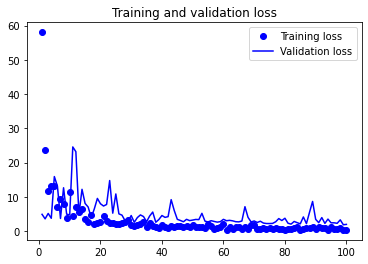

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Hier zien we dat de accuracy minder snel zakt, we hebben zelf nog een goed resultaat rond epoch 75.

In [ ]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

7/7 [==============================] - 4s 161ms/step - loss: 0.8099 - accuracy: 0.9700
Test accuracy: 0.970


Hier zien we dat de accuracy voor de test data 97% is, dit is nog 1% beter dan VGG16.

# ResNet50

Hier ga ik nu gebruik maken van het pretrained convnet ResNet, voor de rest blijft de manier van werken gelijk aan het vorige model (VGG16).

In [ ]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(
    include_top=False, 
    weights="imagenet")
for layer in base_model.layers:
    layer.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),])

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 39.5459 - accuracy: 0.8475

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


25/25 [==============================] - 19s 493ms/step - loss: 39.5459 - accuracy: 0.8475 - val_loss: 22.4250 - val_accuracy: 0.8850
Epoch 2/100
25/25 [==============================] - 11s 418ms/step - loss: 7.3782 - accuracy: 0.9463 - val_loss: 11.7323 - val_accuracy: 0.8800
Epoch 3/100
25/25 [==============================] - 11s 375ms/step - loss: 4.0298 - accuracy: 0.9525 - val_loss: 13.4557 - val_accuracy: 0.9200
Epoch 4/100
25/25 [==============================] - 11s 417ms/step - loss: 9.6258 - accuracy: 0.9488 - val_loss: 9.7121 - val_accuracy: 0.9400
Epoch 5/100
25/25 [==============================] - 11s 415ms/step - loss: 3.3488 - accuracy: 0.9725 - val_loss: 5.2000 - val_accuracy: 0.9550
Epoch 6/100
25/25 [==============================] - 11s 416ms/step - loss: 6.4571 - accuracy: 0.9513 - val_loss: 4.2568 - val_accuracy: 0.9600
Epoch 7/100
25/25 [==============================] - 12s 417ms/step - loss: 1.1841 - accuracy: 0.9837 - val_loss: 4.1588 - val_accuracy: 0.9700


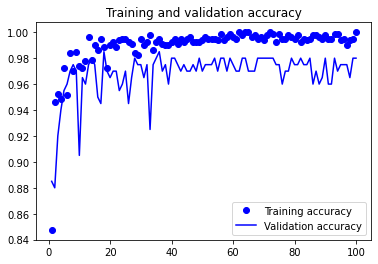

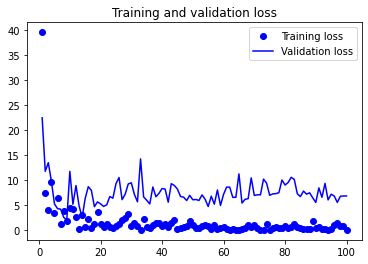

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Hier kunnen we weer zien dat de validation accuracy ongeveer gelijk blijf na de 40ste epoch.

In [ ]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

7/7 [==============================] - 3s 192ms/step - loss: 4.7855 - accuracy: 0.9700
Test accuracy: 0.970


Ook zien we dat dit model een accuracy behaald van 97% op de test data.

# EfficientNet

Bij dit model waren er heel wat problemen met incompatibele methodes, dit heb ik moeten oplossen door de libraries te verlagen naar een vorige versie.

* tensorflow==2.1
* Keras==2.3.1
* tensorflow-probability==0.7.0
* gast==0.2.2
* h5py==2.10.0

Ook heb ik de librarys moeten downloaden om het EfficientNet te kunnen gerbuiken.

* segmentation_models
* efficientnet

In [ ]:
!pip install q tensorflow==2.1
!pip install q keras==2.3.1
!pip install q tensorflow-probability==0.7.0
!pip install q gast==0.2.2
!pip install q segmentation_models
!pip install q efficientnet
!pip install q h5py==2.10.0

     |████████████████████████████████| 421.8 MB 27 kB/s 
     |████████████████████████████████| 3.8 MB 31.2 MB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 
     |████████████████████████████████| 448 kB 52.5 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=4777abb89f947c8dbeb65c5524a921d81647f75026f90be2e67e444865d8d317
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

Hier heb ik een andere manier moeten toepassen om de datasets de genereren en augmentatie toe te passen, dit heb ik moeten doen omdat de vorige methodes waarop we dit gedaan hebben niet compatibel zijn met deze versies van keras en tensorflow.

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory("Picasso_Rubens_400_100_100/train", batch_size = 32, class_mode = 'binary', target_size = (224, 224))

validation_generator = test_datagen.flow_from_directory( "Picasso_Rubens_400_100_100/validation", batch_size = 32, class_mode = 'binary', target_size = (224, 224))
test_generator = test_datagen.flow_from_directory( "Picasso_Rubens_400_100_100/test", batch_size = 32, class_mode = 'binary', target_size = (224, 224))

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
import segmentation_models as sm
import efficientnet.keras as efn
sm.set_framework('tf.keras')
sm.framework()

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


'tf.keras'

We maken gebruik van de eerste versie van EfficientNet (EfficientNetB0) omdat de andere modellen iet wat te complex zijn voor een simpele binary classification, de rest van dit proces is weer gelijkaardig aan dit van VGG16. 

In [ ]:
base_model = efn.EfficientNetB0(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

16809984/16804768 [==============================] - 1s 0us/step


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

In [ ]:
x = base_model.output
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)
model = keras.Model(base_model.input, outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")]

In [ ]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=callbacks)

Epoch 1/100
40/40 [==============================] - 27s 668ms/step - loss: 7.3599 - accuracy: 0.7675 - val_loss: 1.3211 - val_accuracy: 0.8700
Epoch 2/100
40/40 [==============================] - 19s 482ms/step - loss: 5.1189 - accuracy: 0.8462 - val_loss: 8.4416 - val_accuracy: 0.8900
Epoch 3/100
40/40 [==============================] - 21s 529ms/step - loss: 3.6724 - accuracy: 0.8888 - val_loss: 3.4397 - val_accuracy: 0.8850
Epoch 4/100
40/40 [==============================] - 22s 538ms/step - loss: 3.4165 - accuracy: 0.8925 - val_loss: 6.5375 - val_accuracy: 0.8500
Epoch 5/100
40/40 [==============================] - 22s 547ms/step - loss: 3.4873 - accuracy: 0.8888 - val_loss: 0.4067 - val_accuracy: 0.9050
Epoch 6/100
40/40 [==============================] - 21s 521ms/step - loss: 2.9194 - accuracy: 0.9000 - val_loss: 4.7055 - val_accuracy: 0.8600
Epoch 7/100
40/40 [==============================] - 22s 538ms/step - loss: 2.5085 - accuracy: 0.9112 - val_loss: 3.4114 - val_accuracy:

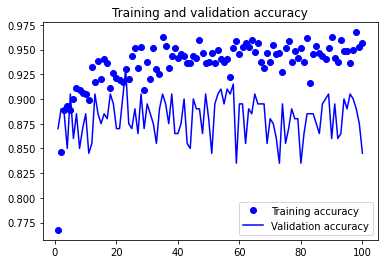

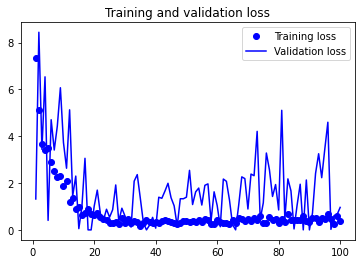

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 4s 381ms/step
Test accuracy: 0.975


Ik heb deze code 2 maal uitgevoerd, één maal voor B7 omdat dit de laaste versie is van EfficientNet, toen had ik een test accuracy van 91.5%. Wanneer ik dan hetzelfde heb gedaan voor B0 dan had ik een test accuracy van 97.5% dit is heel wat beter dan B7.

Hieruit kunnen we besluiten dat een complexer model (B7) slechter is voor een binaire classificatie.

# Conclusie

We kunnen hieruit concluderen dat EfficientNet het beste model is om schilderijen te voorspellen, hierdoor zal ik ook dit model gebruiken om multi class classification te voorspellen met de schilderijen.

Nog een korte samenvatting:

* VGG16: 96%
* Inception: 97%
* ResNet50: 97%
* EfficientNet: 97.5%

Ook kunnen we zeggen dat Inception beter is dan ResNet in deze situatie omdat Incpetion sneller kan trainen dan het ResNet50 model.